This notebook accompanies the paper "Benchmarking Machine Learning Software and Hardware for Quantitative Economics" and shows how to solve the sovereign default model of Arellano (AER 2008) using TensorFlow. For a desciption of the model, see the main text or https://lectures.quantecon.org/py/arellano.html.

In [ ]:
# Import libraries
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# grid for log endowment
logy_grid = np.loadtxt('./Sovereign_Default/logy_grid.txt', dtype=np.float32)

# Transition matrix, computed with Tauchen's method
Py = np.loadtxt('./Sovereign_Default/P.txt', dtype=np.float32)

# Grid size for bond holdings
nB = 351

# Grid size for endowment
ny = len(logy_grid)

# Model parameters
β = .953
γ = 2.
r = 0.017
θ = 0.282

In [ ]:
''' Here we will define the computation graph. By default, TensorFlow executes in graph mode, so
    none of these intermediary operations are executed in this block. In this application,
    this eliminates overhead.'''

# Grid for bond holdings
Bgrid = tf.linspace(-.45, .45, nB)
ygrid = tf.exp(logy_grid)

# Initialize value functions and bond price
Vd = tf.Variable(tf.zeros([ny, 1]))   # Value function when if sov. defaults
Vc = tf.Variable(tf.zeros((ny, nB)))  # Value function when if sov. does not default
V = tf.Variable(tf.zeros((ny, nB)))   # Value function
Q = tf.Variable(tf.ones((ny, nB)) * .95)  # Bond price

# Expectations
EV = Py @ V
EVd = Py @ Vd
EVc = Py @ Vc

# Reshape grids to facilitate broacasting operations. Dimensions are:
# 0: endowment dimension
# 1: Bondholdings dimension
# 2: Bondholdings in the next period dimension
y = tf.reshape(ygrid, [-1, 1, 1])
B = tf.reshape(Bgrid, [1, -1, 1])
Bnext = tf.reshape(Bgrid, [1, 1, -1])

zero_ind = nB // 2  # Index of zero bond holdings

# Utility function
def u(c):
    return c**(1 - γ) / (1 - γ)

ymean = tf.reduce_mean(ygrid)

# Endowment in autarky
def_y = tf.minimum(0.969 * ymean, ygrid)

# bellman target for Vd
Vd_target = u(def_y) + β * (θ * EVc[:, zero_ind] + (1 - θ) * EVd[:, 0])
Vd_target = tf.reshape(Vd_target, [-1, 1])

# bond price next period
Qnext = tf.expand_dims(Q, axis=1)

# Bellman target for Vc
c = tf.maximum(y - Qnext * Bnext + B, 1e-14)
EV = tf.expand_dims(EV, axis=1)
m = u(c) + β * EV
Vc_target = tf.reduce_max(m, axis=2)

# Update bond price--- risk neutral pricing
default_states = tf.cast(Vd > Vc, tf.float32)
default_prob = Py @ default_states
Q_target = (1 - default_prob) / (1 + r)

# Value function
V_target = tf.maximum(Vc, Vd)

# Create operations to update all tensors
update_V = V.assign(V_target)
update_Vc = Vc.assign(Vc_target)
update_Vd = Vd.assign(Vd_target)
update_Q = Q.assign(Q_target)
update = tf.group(update_V, update_Vc, update_Vd, update_Q)

In [5]:
''' This is the block in which we execute the operations defined above. Before this execution, we must first 
launch a session. This is what ensures that the operations will be executed using C++ and CUDA kernels as opposed
to being executed by the Python interpreter.'''

# We instruct TensorFlow to use the XLA compiler (optional).
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = 1

# Now we launch the session and initialize global variables
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

# Finally we iterate until convergence. Iterating means executing the "update" operation
# defined in the block above. We say that the procedure "converged" if the difference between Q
# and it's previous value is less than 1e-8. Finally we monitor that difference by printing it
# every 20 iterations
Q_ = sess.run(Q)  # Q_ is the numerical value of the symbolic tensor Q
for counter in range(10000):
    sess.run(update)
    
    if counter % 20 == 0:
        Qnew_ = sess.run(Q)
        error = np.abs(Qnew_ - Q_).max()
        print(error)
        Q_ = Qnew_
        if error < 1e-8 and counter > 0:
            break


0.033284247
0.98328435
0.98328435
0.11247155
0.0


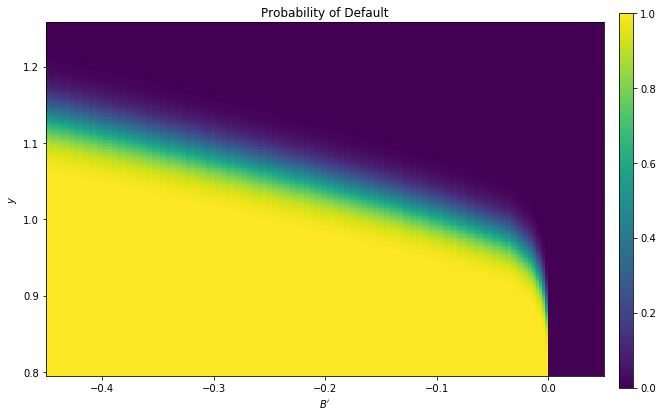

In [6]:
# Create plots
xx, yy = sess.run([Bgrid, ygrid])
zz = sess.run(default_prob)

fig, ax = plt.subplots(figsize=(10, 6.5))
hm = ax.pcolormesh(xx, yy, zz)
cax = fig.add_axes([.92, .1, .02, .8])
fig.colorbar(hm, cax=cax)
ax.axis([xx.min(), 0.05, yy.min(), yy.max()])
ax.set(xlabel="$B'$", ylabel="$y$", title="Probability of Default")
plt.show()